<a href="https://colab.research.google.com/github/hrutkabence/tutorials/blob/master/hungarian/machine_learning/lessons/SAM_img_segmentation_hun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM alkalamzása ortofotókon

## 1.) Ki az a SAM?

A [Segment Anything Model (SAM)](https://segment-anything.com) a MetaAI által kifejlesztett mélytanulási modell, amelyet arra terveztek, hogy adott képen, képeken különböző típusú objektumokat különítsen el, szegmentáljon.
A modellt [11 millió képből és 1,1 milliárd maszkból](https://segment-anything.com/dataset/index.html) álló adathalmazon tanították be.



![](https://github.com/facebookresearch/segment-anything/raw/main/assets/model_diagram.png?raw=true)


## 2.) Google Colab környezetet előkészítése

### Alkalmazásához szükséges lépések Google Colab környezetben:

- A futtatókörnyezetnél állítsuk be a GPU-t!
- Töltsük le, klónozzuk [SAM GitHub](https://github.com/facebookresearch/segment-anything.git) könyvtárat.
- Hozzunk létre egy új mappát a virtuális gépünkön (/content/segment-anything), majd telepítsük.
- Töltsünk le egy már kész, betanított modellt (pl.: sam_vit_h_4b8939.pth)
- Telepítsük [supervision](https://github.com/roboflow/supervision) modult.

### Hogyan néz ki ez a gyakorlatban?

In [1]:
!git clone 'https://github.com/facebookresearch/segment-anything.git'

Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.30 MiB | 12.23 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 838.7 kB/s eta 0:00:00


In [3]:
pip install opencv-python pycocotools matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.5 MB/s eta 0:00:00


Töltsük le a modellt (~2.5GB!)
a következő link segítségével.
https://github.com/facebookresearch/segment-anything#model-checkpoints

In [4]:
%cd segment-anything
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content/segment-anything


## 3.) Model alkalmazása

### a.) Földterületek szegmentálása műholdfelvételről

Első lépésként inicializáljuk a modellt. Ehhez a virtuális számítógépünk videókártáját fogjuk hasznánli.

In [5]:
import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

# Töltsük be a letöltött modellt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
CHECKPOINT_PATH = "./sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# Inicializájuk a SAM automatikus maszk generálóját
mask_generator = SamAutomaticMaskGenerator(sam)

Töltsünk le egy fotót!

In [13]:
!wget -q -O sample_image_sat.png https://github.com/hrutkabence/tutorials/blob/master/english/machine_learning/lessons/data/sample_image_sat.png?raw=true

Adjuk meg a letölött kép helyét!

In [14]:
image_path = 'sample_image_sat.png'

Jelenítsük meg az eredeti fotót.

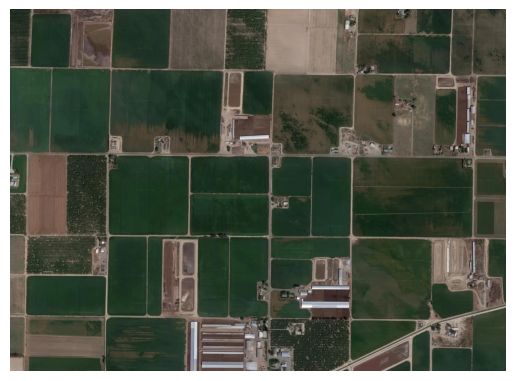

In [15]:
import cv2                        # Képfeldolgozás
import supervision as sv          # Maszkok kirajzolása
import matplotlib.pyplot as plt   # Megjelenítés

# Olvassuk be a fotót az OpenCV segítségével, majd cseréljük meg a beolvasott BGR sorrendet RGB-re.
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Jelenítsük meg a fotót
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


Alkamazzuk a SAM-et a képen!

In [16]:
# Generating masks using SAM
sam_result = mask_generator.generate(image_rgb)

A maszkok megjelenítésére használjuk fel a supervision modult.

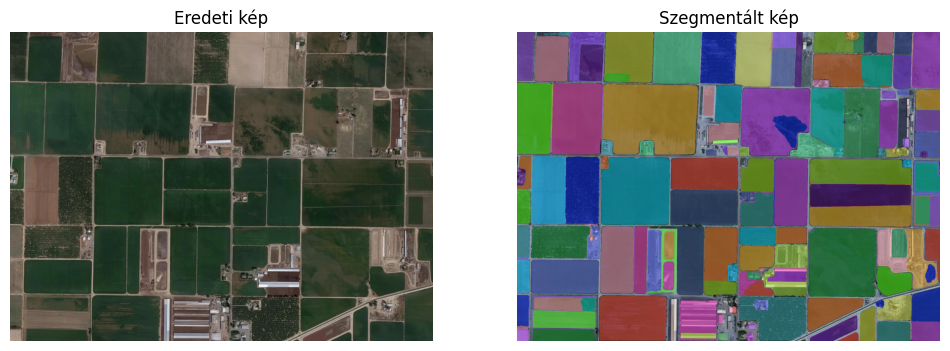

In [17]:
# MaskAnnotator inicializálása
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# SAM eredmények konvertálása supervision formátumává
detections = sv.Detections.from_sam(sam_result=sam_result)

# Szegmentált maszkok megjelenításe különböző színekkel
annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

# Jelenítsük meg a modellt.
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['Eredeti kép', 'Szegmentált kép']
)

### b.) Szegmentálás ortofotón

Töltsünk le egy ortofotót, vagy bármilyen tetszőleges fotót és használjuk az előző kódot!

In [29]:
!wget -q !wget -q -O BME_K_building.tiff https://github.com/hrutkabence/tutorials/blob/master/english/machine_learning/lessons/data/BME_K_building.tiff?raw=true
image_orto = './BME_K_building.tiff'

Az egyszerűbb használhatóságért készítsünk egy függvényt:

In [30]:
def sam(image_path, mask_generator):
  image_bgr = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  sam_result = mask_generator.generate(image_rgb)
  mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# SAM eredmények konvertálása supervision formátumává
  detections = sv.Detections.from_sam(sam_result=sam_result)

# Szegmentált maszkok megjelenításe különböző színekkel
  annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

  # Jelenítsük meg a modellt.
  sv.plot_images_grid(
      images=[image_bgr, annotated_image],
      grid_size=(1, 2),
      titles=['Eredeti kép', 'Szegmentált kép']
  )


Használjuk a függvényt és szegmentáljunk!

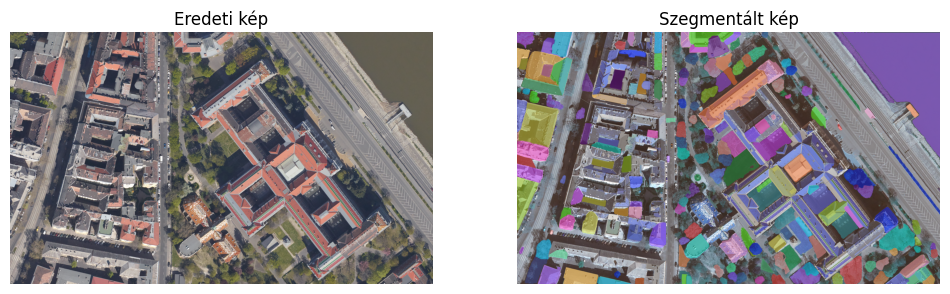

In [31]:
sam(image_orto, mask_generator)

### További feladat

Exportáljuk a szegmenseket!

## Felhasznált irodalom

- https://medium.com/stackademic/high-resolution-or-low-resolution-image-does-it-matter-for-the-segment-anything-model-sam-9eeb229ad9c0


- https://medium.com/@mahyar.aboutalebi/which-version-of-the-segment-anything-model-sam-can-detect-more-objects-python-2bc7d3d80234


- https://github.com/facebookresearch/segment-anything#model-checkpoints
